In [2]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import ttest_ind, boxcox
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb



In [3]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


In [4]:
all_um_data = pd.read_csv('../Data/UM_data_top_100.csv')

In [5]:
all_um_data = all_um_data.drop(columns=['Unnamed: 0'])

In [6]:
all_um_data['state_code'].fillna('VA', inplace=True)

/var/folders/_4/_j38q0cn0kg4pnd1jf3yvymr0000gn/T/ipykernel_66352/239289188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_um_data['state_code'].fillna('VA', inplace=True)


In [7]:
all_um_data = all_um_data[all_um_data['true age'] < 100]

In [8]:
# change females and males to 0 and 1 respectively
all_um_data['Athlete gender'] = all_um_data['Athlete gender'].map({'F': 0, 'M': 1})

In [9]:
all_um_data.rename(columns={'Athlete gender': "Gender"}, inplace=True)
all_um_data.rename(columns={'Average state elevation (feet)': "State_elevation"}, inplace=True)
all_um_data.rename(columns={'true age': "true_age"}, inplace=True)
all_um_data.rename(columns={'Distance (miles)': "distance"}, inplace=True)

In [10]:
all_um_data = all_um_data[all_um_data['true_age'] > 7]

In [11]:
females = all_um_data[all_um_data['Gender'] == 0]['mph']
males = all_um_data[all_um_data['Gender'] == 1]['mph']
t_stat, p_value = ttest_ind(females, males, equal_var=False)
print(f't-statistic: {t_stat}, p-value: {p_value}')

t-statistic: -94.47516203727959, p-value: 0.0


In [14]:
featured_data = all_um_data[['Gender', 'true_age', 'distance','mph', 'State_elevation']]

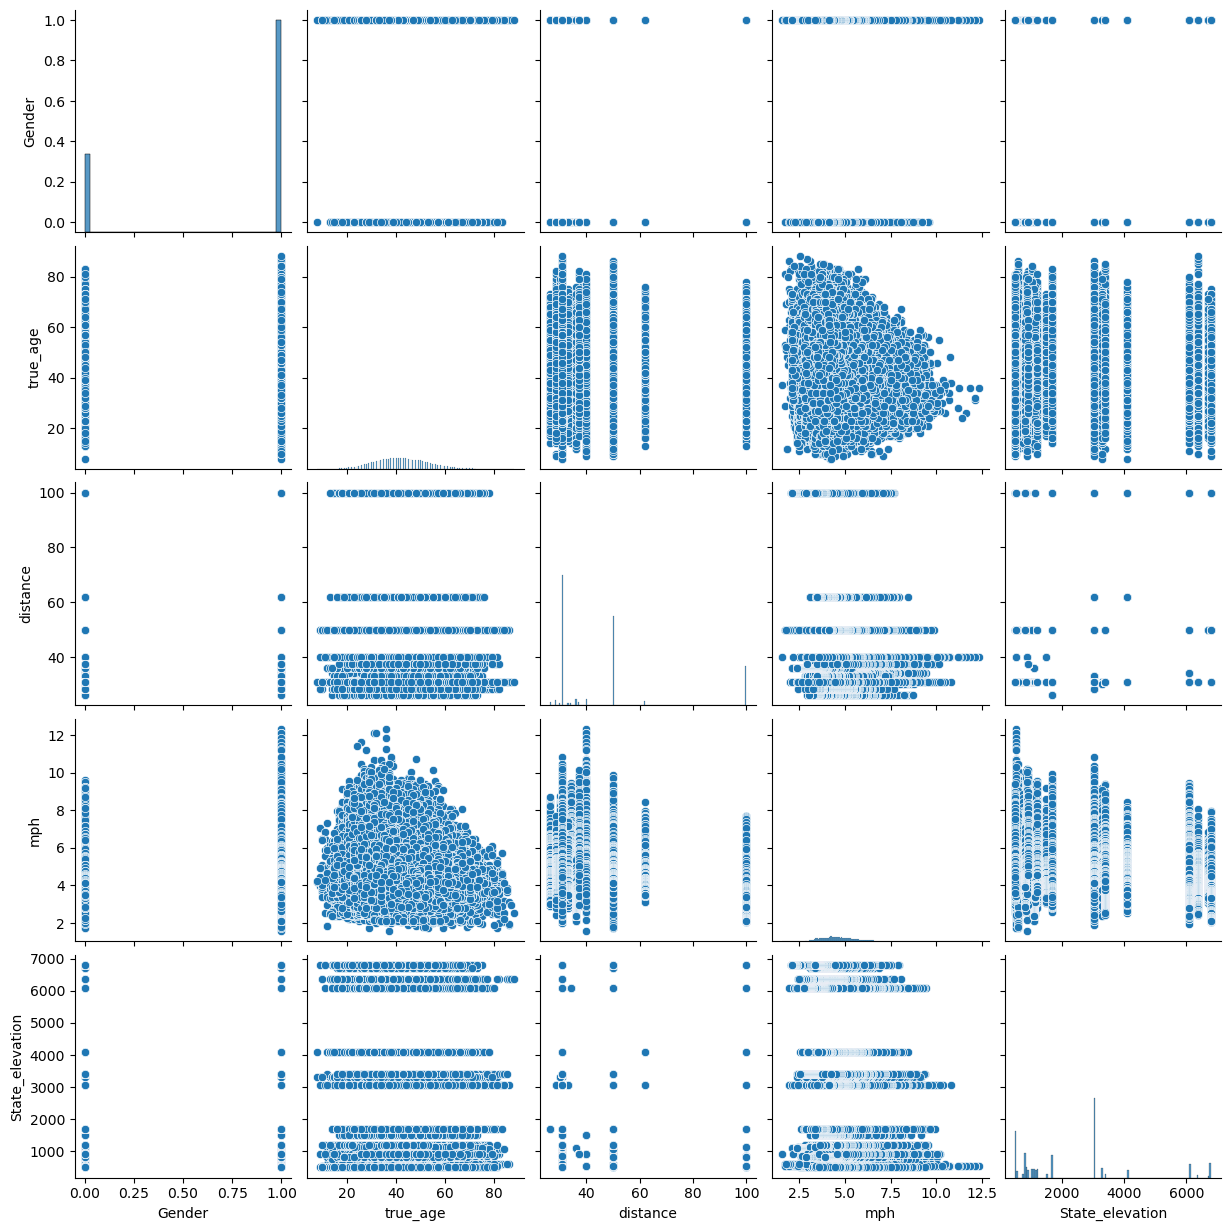

In [15]:
sns.pairplot(featured_data)

In [12]:
all_um_data.head()

,Year of event,Event name,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Gender,Athlete age category,Athlete ID,true_age,State,Highest Elevation (feet),Elevation Gain (feet),State_elevation,distance,Hours Ran,mph,state_code,datetime
0,2018,Chuckanut 50K (USA),410,3:36:35,"*Folsom, CA",USA,1991,1,23,12058,27,Washington,1870.0,5000.0,1700.0,31.0,3.609722,8.587918,WA,2018-03-17
1,2018,Chuckanut 50K (USA),410,3:40:57,"*Santa Fe, NM",USA,1986,1,23,12059,32,Washington,1870.0,5000.0,1700.0,31.0,3.682500,8.418194,WA,2018-03-17
2,2018,Chuckanut 50K (USA),410,3:47:43,"*San Francisco, CA",IRL,1987,1,23,12060,31,Washington,1870.0,5000.0,1700.0,31.0,3.795278,8.168045,WA,2018-03-17
3,2018,Chuckanut 50K (USA),410,3:48:13,"*Ashland, OR",USA,1988,1,23,12061,30,Washington,1870.0,5000.0,1700.0,31.0,3.803611,8.150150,WA,2018-03-17
4,2018,Chuckanut 50K (USA),410,3:50:55,"*Bend, OR",USA,1981,1,35,12062,37,Washington,1870.0,5000.0,1700.0,31.0,3.848611,8.054854,WA,2018-03-17


In [13]:
X = all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]
y= all_um_data['mph']


In [14]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    mph   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                          8.883e+05
Date:                Mon, 09 Dec 2024   Prob (F-statistic):                        0.00
Time:                        12:09:56   Log-Likelihood:                     -7.9401e+05
No. Observations:              424114   AIC:                                  1.588e+06
Df Residuals:                  424110   BIC:                                  1.588e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [16]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred = lin_model.predict(X_test)

In [18]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

0.927758784169388
0.18038069006693602


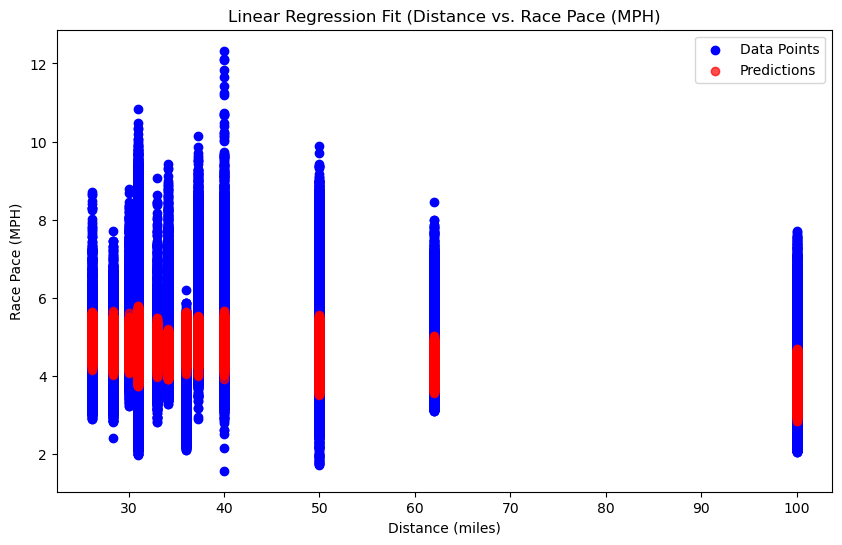

In [19]:
# Visualize the linear regression plot for distance vs race pace (mph)
plt.figure(figsize=(10,6))
plt.scatter(all_um_data['distance'], all_um_data['mph'], color='blue', label = 'Data Points')
plt.scatter(all_um_data['distance'], lin_model.predict(all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]), color='red', alpha=0.7, label='Predictions')
plt.title('Linear Regression Fit (Distance vs. Race Pace (MPH)')
plt.xlabel("Distance (miles)")
plt.ylabel("Race Pace (MPH)")
plt.legend()
plt.show()

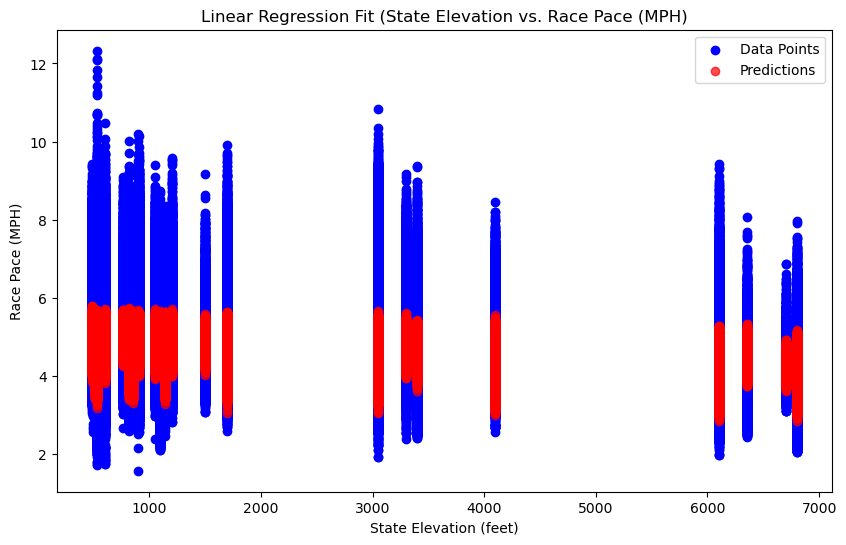

In [20]:
# Visualize the linear regression plot for state elevation vs race pace (mph)
plt.figure(figsize=(10,6))
plt.scatter(all_um_data['State_elevation'], all_um_data['mph'], color='blue', label = 'Data Points')
plt.scatter(all_um_data['State_elevation'], lin_model.predict(all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]), alpha=0.7, color='red', label='Predictions')
plt.title('Linear Regression Fit (State Elevation vs. Race Pace (MPH)')
plt.xlabel("State Elevation (feet)")
plt.ylabel("Race Pace (MPH)")
plt.legend()
plt.show()

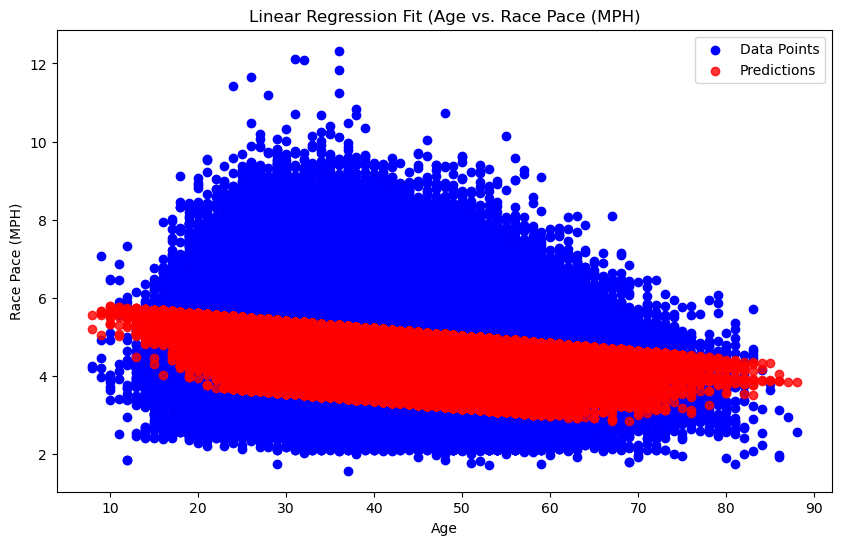

In [21]:
# Visualize the linear regression plot for age vs race pace (mph)
plt.figure(figsize=(10,6))
plt.scatter(all_um_data['true_age'], all_um_data['mph'], color='blue', label = 'Data Points')
plt.scatter(all_um_data['true_age'], lin_model.predict(all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]), alpha = 0.8, color='red', label='Predictions')
plt.title('Linear Regression Fit (Age vs. Race Pace (MPH)')
plt.xlabel("Age")
plt.ylabel("Race Pace (MPH)")
plt.legend()
plt.show()

In [22]:
residuals = y_test - y_pred

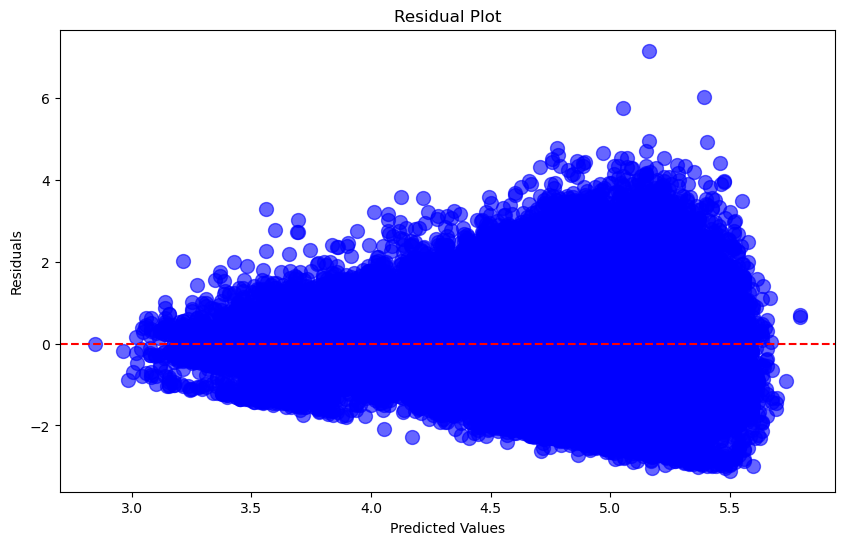

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', s=100, alpha=0.6)
plt.axhline(y=0, color='red', linestyle="--")
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [24]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [25]:
lin_model.predict([[1, 36, 200, 1]]) # Male/Female, age, average state altitude, distance (miles)

array([5.730032])

Create a log transformation to help stabalize the variance

In [26]:
all_um_data['log_mph'] = np.log(all_um_data['mph'])

In [27]:
y1 = all_um_data['log_mph']

In [28]:
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(X, y1, test_size=0.2)

In [29]:
log_lin_model = LinearRegression()
log_lin_model.fit(log_X_train, log_y_train)

LinearRegression()

In [30]:
log_y_pred = log_lin_model.predict(log_X_test)

In [31]:
mse_log = mean_squared_error(log_y_test, log_y_pred)
r2_log = r2_score(log_y_test, log_y_pred)
print(mse_log)
print(r2_log)

0.04051226254795319
0.19031642456490394


In [32]:
residuals_log = log_y_test - log_y_pred

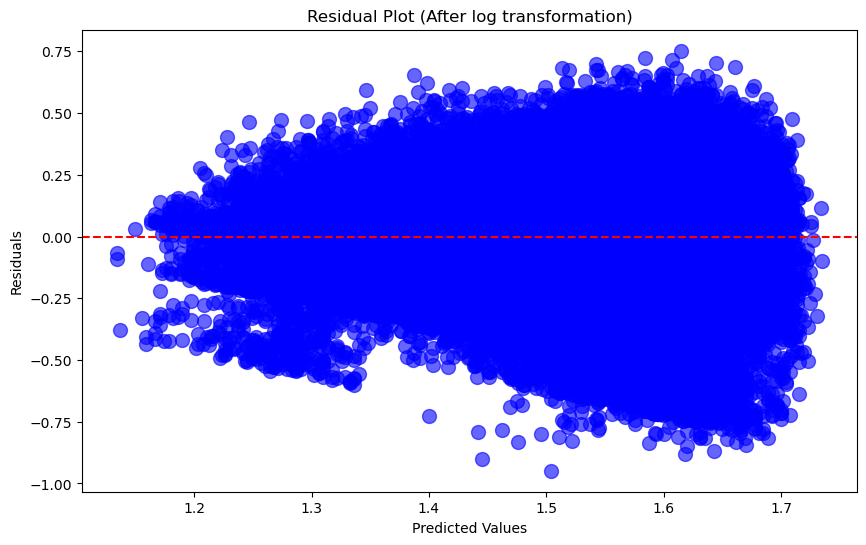

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(log_y_pred, residuals_log, color='blue', s=100, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (After log transformation)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

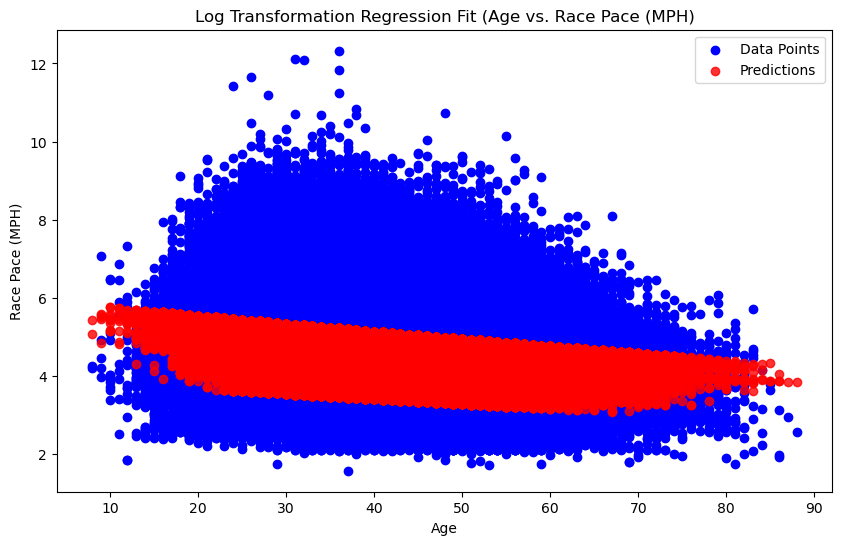

In [56]:
# Visualize the linear regression plot for age vs race pace (mph)
plt.figure(figsize=(10,6))
plt.scatter(all_um_data['true_age'], all_um_data['mph'], color='blue', label = 'Data Points')
plt.scatter(all_um_data['true_age'], np.exp(log_lin_model.predict(all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']])), alpha = 0.8, color='red', label='Predictions')
plt.title('Log Transformation Regression Fit (Age vs. Race Pace (MPH)')
plt.xlabel("Age")
plt.ylabel("Race Pace (MPH)")
plt.legend()
plt.show()

In [35]:
np.exp(log_lin_model.predict([[1, 36, 200, 1]]))

array([5.74332222])

In [36]:
results_log = pd.DataFrame({'Log_actual': log_y_test, 'Log_predicted': log_y_pred})

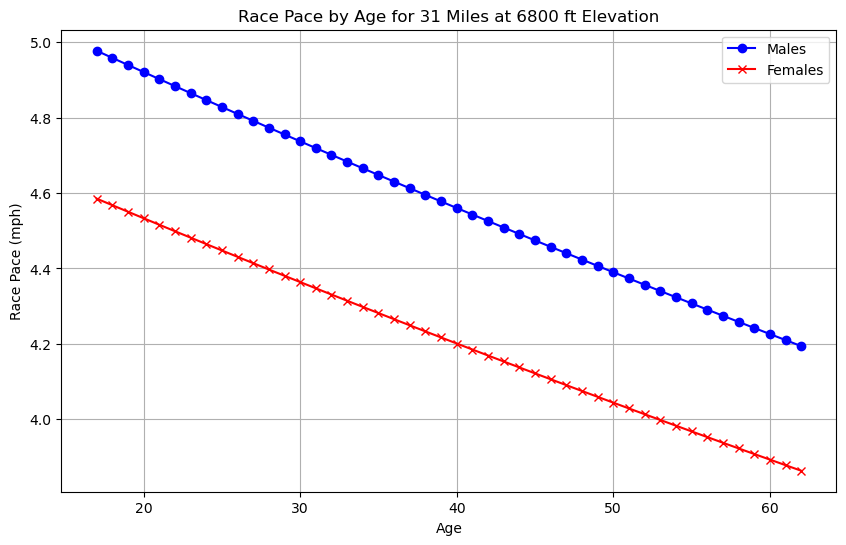

In [ ]:


# Your predict_race_pace function
def predict_race_pace(gender, age, elevation, distance):
    input_data = np.array([[gender, age, elevation, distance]])
    log_predicted_mph = log_lin_model.predict(input_data)
    predicted_mph = np.exp(log_predicted_mph)
    return predicted_mph[0]

# Define the age range
ages = np.arange(17, 63)

# Choose specific elevation and distance
chosen_elevation = 6800  # Example elevation
chosen_distance = 31     # Example distance

# Generate predictions for males and females
male_pace = [predict_race_pace(1, age, chosen_elevation, chosen_distance) for age in ages]
female_pace = [predict_race_pace(0, age, chosen_elevation, chosen_distance) for age in ages]

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot average race pace for males
plt.plot(ages, male_pace, linestyle='-', marker='o', color='b', label='Males')

# Plot average race pace for females
plt.plot(ages, female_pace, linestyle='-', marker='x', color='r', label='Females')

# Customize the plot
plt.xlabel('Age')
plt.ylabel('Race Pace (mph)')
plt.title(f'Race Pace by Age for {chosen_distance} Miles at {chosen_elevation} ft Elevation')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
predict_race_pace(1, 20, 6800, 20)

5.08927967809717

In [39]:
# Lets do a comparison to a military base at high altitude vs a military base at low altidude for the 2 mile run
# The data is from ultra marathon runners from the top ultra marathon races in the United States

# Colorado Males vs Females from Age 20, 30, and 40 at Fort Carson.  Average Elevation is 5,680 feet.
male_20_CO = predict_race_pace(1, 20, 5680, 2)
male_30_CO = predict_race_pace(1, 30, 5680, 2)
male_40_CO = predict_race_pace(1, 40, 5680, 2)
male_50_CO = predict_race_pace(1, 50, 5680, 2)
female_20_CO = predict_race_pace(0, 20, 5680, 2)
female_30_CO = predict_race_pace(0, 30, 5680, 2)
female_40_CO = predict_race_pace(0, 40, 5680, 2)
female_50_CO = predict_race_pace(0, 50, 5680, 2)




In [40]:
print(male_20_CO, female_20_CO)
print(male_30_CO, female_30_CO)
print(male_40_CO, female_40_CO)
print(male_50_CO, female_50_CO)


5.491637388880045 5.059068234224847
5.2866577699799375 4.870234594053908
5.089329174115239 4.688449315756995
4.899366020925314 4.513449313768092


In [41]:
# Georgia Males vs Females from age 20, 30, and 40 at Fort Eisenhower. Average Elevation is 446 feet.

male_20_GA = predict_race_pace(1, 20, 446, 2)
male_30_GA = predict_race_pace(1, 30, 446, 2)
male_40_GA = predict_race_pace(1, 40, 446, 2)
male_50_GA = predict_race_pace(1, 50, 446, 2)
female_20_GA = predict_race_pace(0, 20, 446, 2)
female_30_GA = predict_race_pace(0, 30, 446, 2)
female_40_GA = predict_race_pace(0, 40, 446, 2)
female_50_GA = predict_race_pace(0, 50, 446, 2)

In [42]:
print(male_20_GA, female_20_GA)
print(male_30_GA, female_30_GA)
print(male_40_GA, female_40_GA)
print(male_50_CO, female_50_GA)

6.057115414561785 5.580004289229398
5.8310288903814165 5.371726307332187
5.613381220823674 5.171222462423885
4.899366020925314 4.9782025788201905


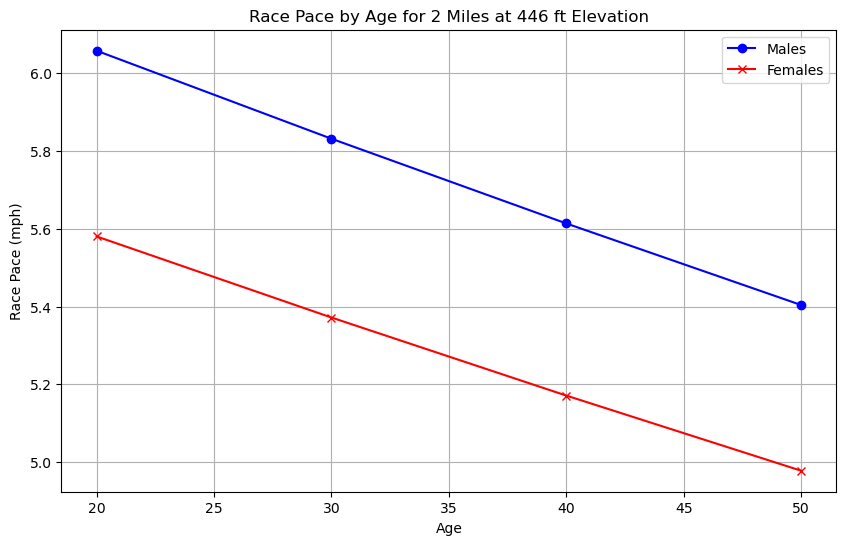

In [43]:


# Define the ages
ages = [20, 30, 40, 50]

# Define the race pace predictions
male_pace = [male_20_GA, male_30_GA, male_40_GA, male_50_GA]
female_pace = [female_20_GA, female_30_GA, female_40_GA, female_50_GA]

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot race pace for males
plt.plot(ages, male_pace, linestyle='-', marker='o', color='b', label='Males')

# Plot race pace for females
plt.plot(ages, female_pace, linestyle='-', marker='x', color='r', label='Females')

# Customize the plot
plt.xlabel('Age')
plt.ylabel('Race Pace (mph)')
plt.title('Race Pace by Age for 2 Miles at 446 ft Elevation')
plt.legend()
plt.grid(True)
plt.show()


### Data hosts top 100, ultramarathon races in the United States from 1963 to 2022.

There are 424,114 rows of data
Age Range is from 8 to 88 years old.
There are 128,168 unique runners.
There are 86,727 individual male runners. 41,480 individual female runners.
Distances range from 26.2 Miles to 100 Miles.

Data to Focus on for features: Gender, Age, Average State Elevation (feet), distance (miles)
Target data: mph (average race pace)



In [44]:
all_um_data[all_um_data['Gender'] == 0].nunique()

Year of event                   55
Event name                     100
Event number of finishers      484
Athlete performance          42889
Athlete club                  9021
Athlete country                 71
Athlete year of birth           89
Gender                           1
Athlete age category            12
Athlete ID                   41480
true_age                        72
State                           27
Highest Elevation (feet)        66
Elevation Gain (feet)           68
State_elevation                 24
distance                        12
Hours Ran                    42889
mph                          54607
state_code                      25
datetime                      1636
log_mph                      54411
dtype: int64

## Model Tuning

XGBoost can automatically handle non-linearities and interactions, such as how age and elevation together impact race pace differently than they would individually.

Linear Regression might struggle without extensive feature engineering and still might not capture the complex relationships as effectively.

Analysis:

The Mean Squared Error (MSE) of the XGBoost regression model is significantly lower than that of the linear regression model. This indicates that the XGBoost model has better predictive performance, as it makes predictions that are, on average, closer to the actual values.

Box_cox predictions give the closest predictions on average closer to their actual values.

linear regression model has an mse of 0.9278052145504915
xgboost regression model has an mse of 0.6786338021017468

log transformation of linear regression gave me an MSE of 0.05
box cox transformation gives me an MSE of 0.01

Mean Squared Error: 0.012979636721184285
Mean Absolute Error: 0.09010772981562068


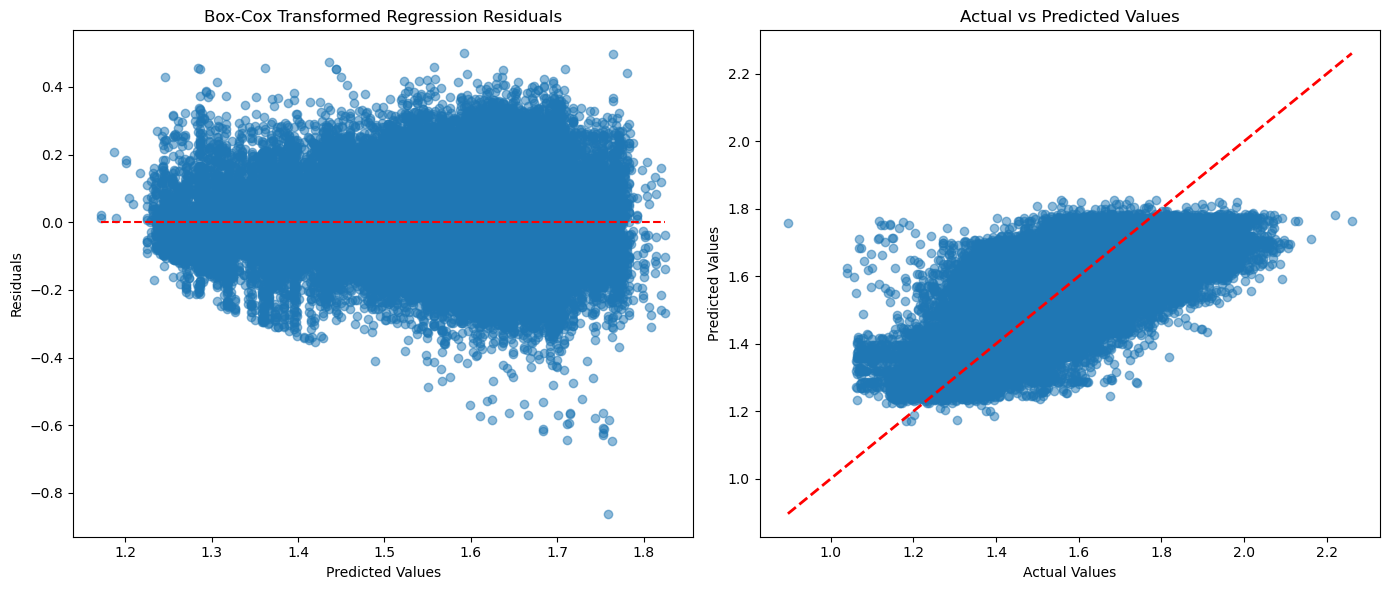

In [45]:

from scipy.stats import boxcox


# Feature matrix (X) and target vector (y)
X = all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]
y = all_um_data['mph']  # Use the original target variable

# Apply Box-Cox transformation to y
# Note: Box-Cox transformation requires all values to be positive
# Add a small constant if needed to make all values positive
# Shift to make all values positive if needed
y_positive = y + 1
y_boxcox, lam = boxcox(y_positive)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)

# Train an XGBoost model (as an example) on the transformed target variable
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Predict on the test set
y_pred_boxcox = model.predict(X_test)

# Inverse Box-Cox transformation for predictions
y_pred = np.exp(y_pred_boxcox * lam) - 1

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_boxcox)
mae = mean_absolute_error(y_test, y_pred_boxcox)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot the residuals and actual vs predicted values if needed
import matplotlib.pyplot as plt

residuals = y_test - y_pred_boxcox

plt.figure(figsize=(14, 6))

# Residuals Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_boxcox, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred_boxcox), xmax=max(y_pred_boxcox), colors='red', linestyles='dashed')
plt.title('Box-Cox Transformed Regression Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Actual vs Predicted Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_boxcox, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


In [46]:

# Function to predict race pace and apply inverse Box-Cox transformation
def predict_race_pace_xgb(model, gender, age, elevation, distance, lam):
    input_data = np.array([[gender, age, elevation, distance]])
    predicted_boxcox = model.predict(input_data)
    if lam == 0:
        predicted_mph = np.exp(predicted_boxcox)
    else:
        predicted_mph = (np.exp(np.log(lam * predicted_boxcox + 1) / lam)) - 1
    return predicted_mph[0]

# Example input values
gender = 1
age = 20
elevation = 5680
distance = 2

# Predict race pace
predicted_race_pace = predict_race_pace_xgb(model, gender, age, elevation, distance, lam)
print(f'Predicted Race Pace: {predicted_race_pace:.2f} mph')


Predicted Race Pace: 4.12 mph


I used box cox transformation due to greater flexibility and adapatability.  I wanted to fix the variance in my data.

The data had skewness and heteroscedasticity.  Box Cox effectively stabalized the variance leading to more reliable and consistent model performance.

The model can now make more accurate predictions to a certain degree (model predicted for races from 26 to 100 miles).

Box cox enhances performance of linear regression models, which assume normally distributed residuals.

The normalization helped achieve a more normal distribution of the traget variable enhancing model performance.

Box Cox made my data more uniform for stabalizing the variance.  The data is now more normally distributed.

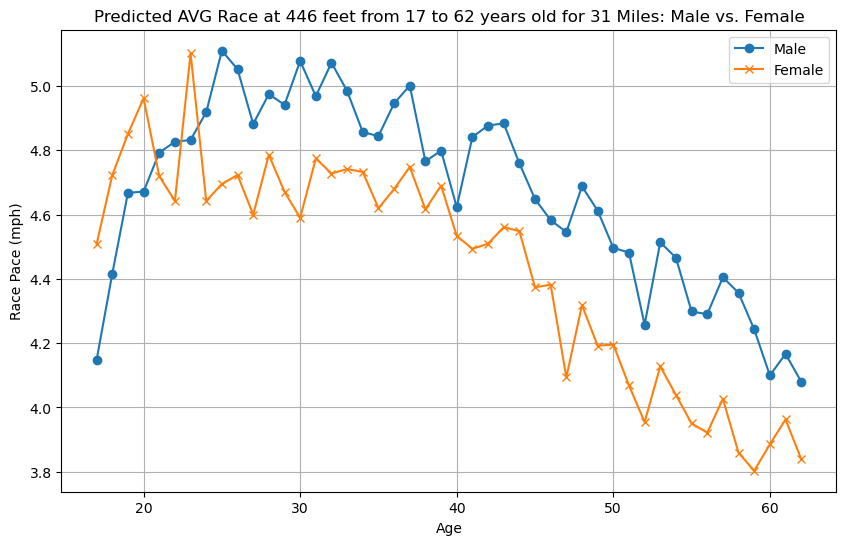

In [47]:
ages = range(17,63)
elevations = 446
distances = 2
predictions_male = [predict_race_pace_xgb(model, 1, age, elevations, distances, lam)for age in ages]
predictions_female = [predict_race_pace_xgb(model, 0, age, elevations, distances, lam)for age in ages]

plt.figure(figsize=(10, 6)) 
plt.plot(ages, predictions_male, label='Male', linestyle='-', marker='o') 
plt.plot(ages, predictions_female, label='Female', linestyle='-', marker='x') 
plt.xlabel('Age') 
plt.ylabel('Race Pace (mph)') 
plt.title('Predicted AVG Race at 446 feet from 17 to 62 years old for 31 Miles: Male vs. Female') 
plt.legend() 
plt.grid(True) 
plt.show()

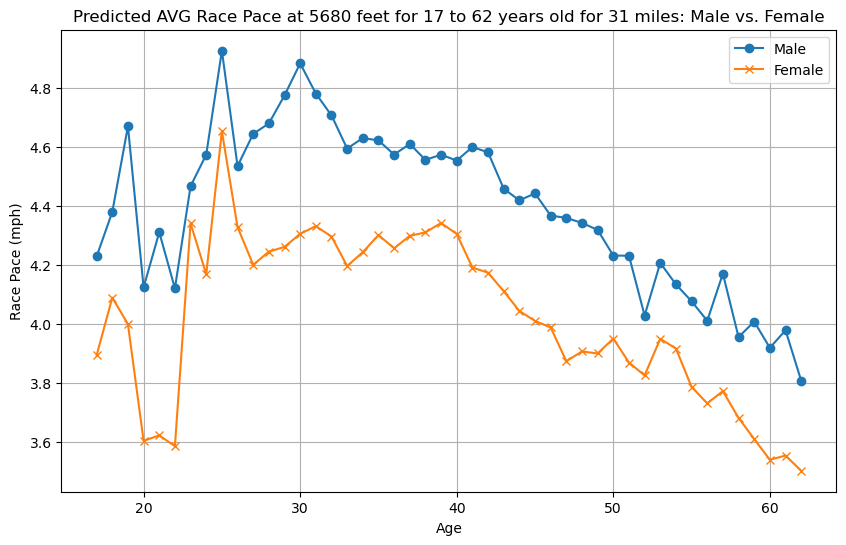

In [48]:
ages2 = range(17,63)
elevation2 = 5680
distance2 = 2
predictions_male = [predict_race_pace_xgb(model, 1, age, elevation2, distance2, lam)for age in ages2]
predictions_female = [predict_race_pace_xgb(model, 0, age, elevation2, distance2, lam)for age in ages2]

plt.figure(figsize=(10, 6)) 
plt.plot(ages, predictions_male, label='Male', linestyle='-', marker='o') 
plt.plot(ages, predictions_female, label='Female', linestyle='-', marker='x') 
plt.xlabel('Age') 
plt.ylabel('Race Pace (mph)') 
plt.title('Predicted AVG Race Pace at 5680 feet for 17 to 62 years old for 31 miles: Male vs. Female') 
plt.legend() 
plt.grid(True) 
plt.show()

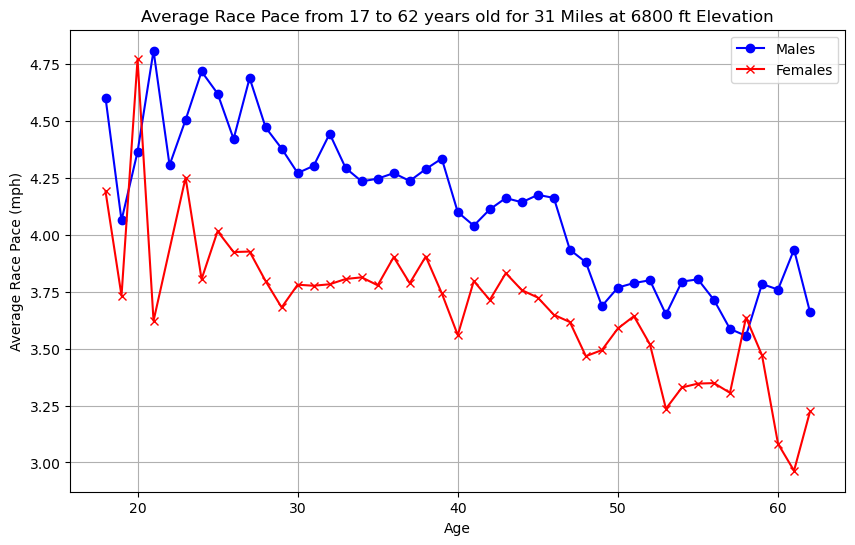

In [49]:

# Choose specific distance and elevation
chosen_distance = 31
chosen_elevation = 6800  # Example elevation

# Filter data by the chosen distance and elevation
filtered_data = all_um_data[(all_um_data['distance'] == chosen_distance) & (all_um_data['State_elevation'] == chosen_elevation) & (all_um_data['true_age'] >= 17) & (all_um_data['true_age'] <= 62)]

# Calculate average race pace for each age group by gender
average_pace_by_age_male = filtered_data[filtered_data['Gender'] == 1].groupby('true_age')['mph'].mean().reset_index()
average_pace_by_age_female = filtered_data[filtered_data['Gender'] == 0].groupby('true_age')['mph'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot average race pace for males
plt.plot(average_pace_by_age_male['true_age'], average_pace_by_age_male['mph'], linestyle='-', marker='o', color='b', label='Males')

# Plot average race pace for females
plt.plot(average_pace_by_age_female['true_age'], average_pace_by_age_female['mph'], linestyle='-', marker='x', color='r', label='Females')

# Customize the plot
plt.xlabel('Age')
plt.ylabel('Average Race Pace (mph)')
plt.title(f'Average Race Pace from 17 to 62 years old for {chosen_distance} Miles at {chosen_elevation} ft Elevation')
plt.legend()
plt.grid(True)
plt.show()



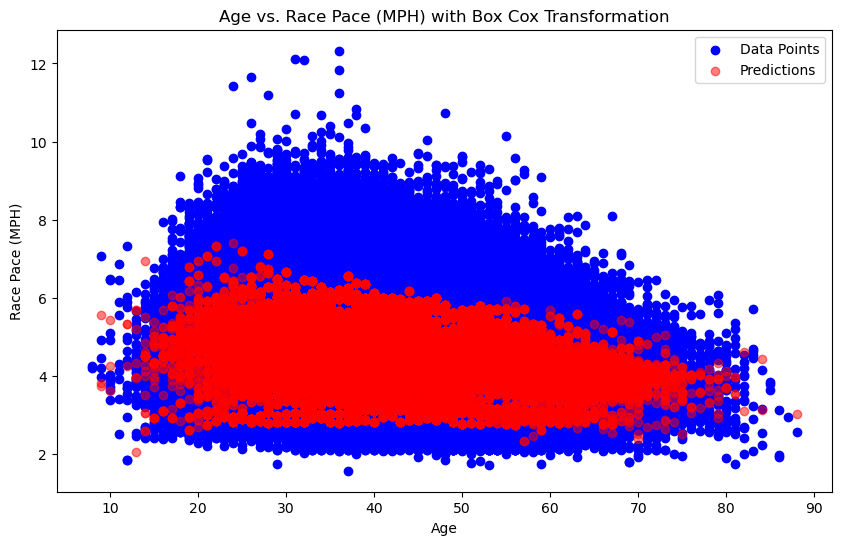

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Example model
from scipy.stats import boxcox
from scipy.special import inv_boxcox


# Define the features and target variable
X = all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]
y = all_um_data['mph']

# Apply Box-Cox transformation to the target variable
y_boxcox, lam = boxcox(y + 1)  # Adding 1 to avoid issues with zero values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)

# Fit the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_boxcox = model.predict(X_test)

# Apply the inverse Box-Cox transformation to the predictions
y_pred = inv_boxcox(y_pred_boxcox, lam) - 1

# Plot the original data and the model predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_um_data['true_age'], all_um_data['mph'], color='blue', label='Data Points')
plt.scatter(X_test['true_age'], y_pred, color='red', alpha=0.5, label='Predictions')
plt.title('Age vs. Race Pace (MPH) with Box Cox Transformation')
plt.xlabel("Age")
plt.ylabel("Race Pace (MPH)")
plt.legend()
plt.show()


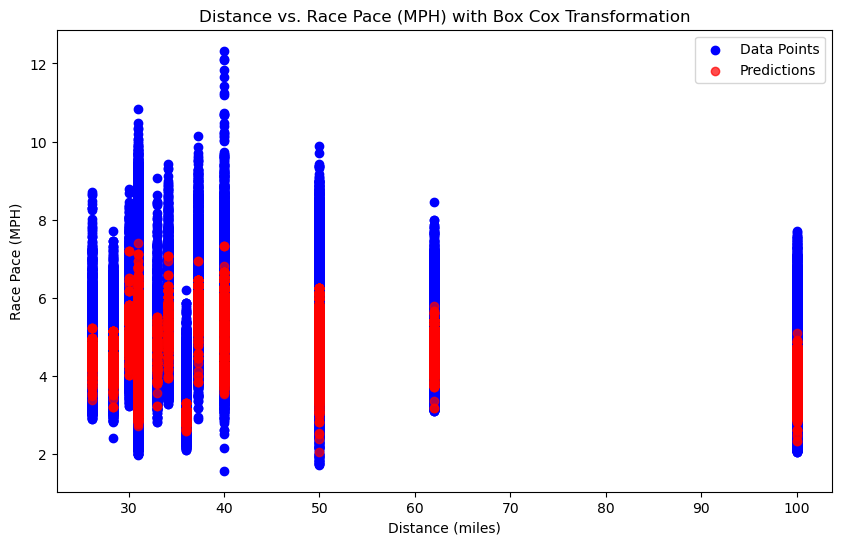

In [51]:
# Visualize the linear regression plot for distance vs race pace (mph)
plt.figure(figsize=(10,6))
plt.scatter(all_um_data['distance'], all_um_data['mph'], color='blue', label = 'Data Points')
plt.scatter(X_test['distance'], y_pred, color='red', alpha=0.7, label='Predictions')
plt.title('Distance vs. Race Pace (MPH) with Box Cox Transformation')
plt.xlabel("Distance (miles)")
plt.ylabel("Race Pace (MPH)")
plt.legend()
plt.show()

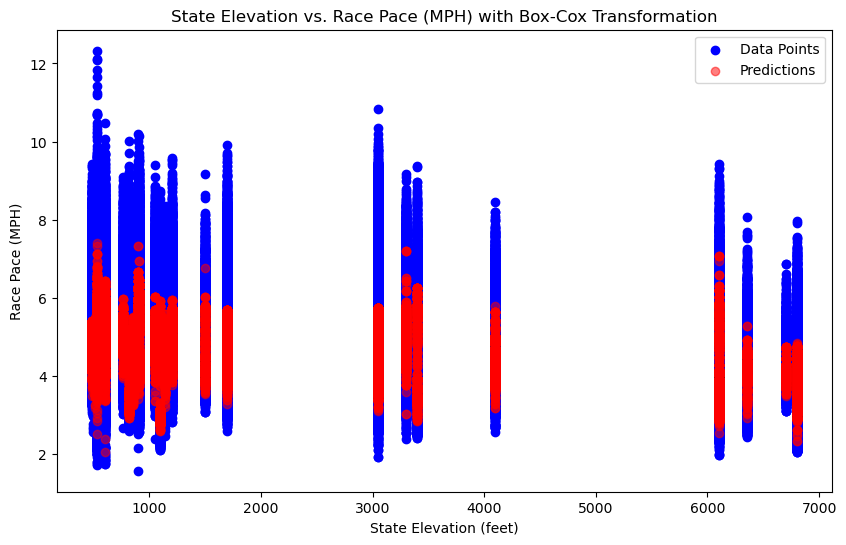

In [52]:

# Plot the original data and the model predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_um_data['State_elevation'], all_um_data['mph'], color='blue', label='Data Points')
plt.scatter(X_test['State_elevation'], y_pred, color='red', alpha=0.5, label='Predictions')
plt.title('State Elevation vs. Race Pace (MPH) with Box-Cox Transformation')
plt.xlabel('State Elevation (feet)')
plt.ylabel('Race Pace (MPH)')
plt.legend()
plt.show()


In [53]:

import scipy.stats as stats
# A common method for this is to use an ANOVA (Analysis of Variance) test if you have more 
# than two distances, or a t-test if you have only two distances.

# Prepare the data: group running pace by distance
distances = all_um_data['distance'].unique()
pace_by_distance = [all_um_data[all_um_data['distance'] == d]['mph'].values for d in distances]

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(*pace_by_distance)

# Output the results
print(f'F-statistic: {f_statistic}')
print(f'p-value: {p_value}')

# Interpret the p-value
if p_value < 0.05:
    print("There is a statistically significant effect of distance on running pace.")
else:
    print("There is no statistically significant effect of distance on running pace.")


F-statistic: 9295.75743990482
p-value: 0.0
There is a statistically significant effect of distance on running pace.


In [54]:
all_um_data['Athlete ID'].nunique()

128168